In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings  #suppress warnings
warnings.filterwarnings("ignore")

In [104]:
housing= pd.read_csv('Housing.csv')
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [105]:
## Number of observations
len(housing.index)

545

In [106]:
housing.shape

(545, 13)

In [107]:
## filter only area and price
df = housing.loc[:,['area','price']]
df.head()

,area,price
0,7420,13300000
1,8960,12250000
2,9960,12250000
3,7500,12215000
4,7420,11410000


In [108]:
## rescaling the variables(both of area and price)
df_columns = df.columns
scaler = MinMaxScaler()  #compress between 0 and 1
df = scaler.fit_transform(df)

##rename columns(since df has become an np array)
df = pd.DataFrame(df)
df.columns = df_columns


df.head()

,area,price
0,0.396564,1.000000
1,0.502405,0.909091
2,0.571134,0.909091
3,0.402062,0.906061
4,0.396564,0.836364


<Axes: xlabel='area', ylabel='price'>

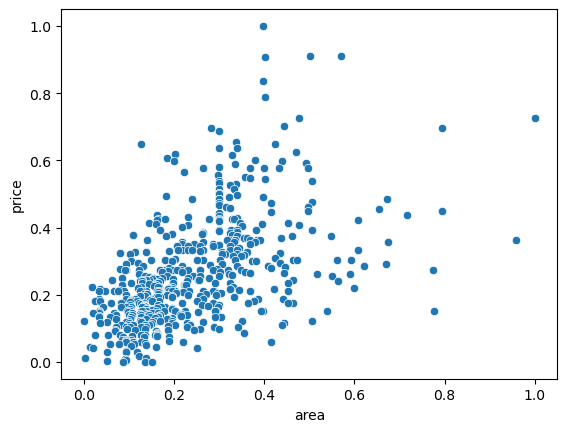

In [109]:
##visualizing area-price relationship
sns.scatterplot(data=df,x='area',y='price')

In [110]:
##splitting into train and test set
df_train,df_test = train_test_split(df,train_size=0.7,
                                    test_size=0.3,
                                    random_state=10)
print(len(df_train))
print(len(df_test))

381
164


In [111]:
#splitting into X and y for both train and test sets
# reshaping is required since sklearn requires data to be in the shape (n,1), and not
#as a Series of (n,)
X_train = df_train['area']
X_train = X_train.values.reshape(-1,1)
y_train = df_train['price']

X_test = df_test['area']
X_test = X_test.values.reshape(-1,1)
y_test = df_test['price']

In [112]:
#creating multiple polynomial features
degrees = [1,2,3,6,10,20]

#initializing test and train predictions and creating a matric where there is train and test prediction against each degree
y_train_pred = np.zeros(shape=(len(X_train),len(degrees)))
y_test_pred  = np.zeros(shape=(len(X_test),len(degrees)))

In [113]:
for i,degree in enumerate(degrees):
    
    ##make pipeline:create polynomial features and fee it to the linear_reg model
    model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
    model.fit(X_train,y_train)
    
    #predicting on train and test data
    #store the predictions of each degress in the corresponding column
    y_train_pred[:,i] = model.predict(X_train)
    y_test_pred[:,i] = model.predict(X_test)

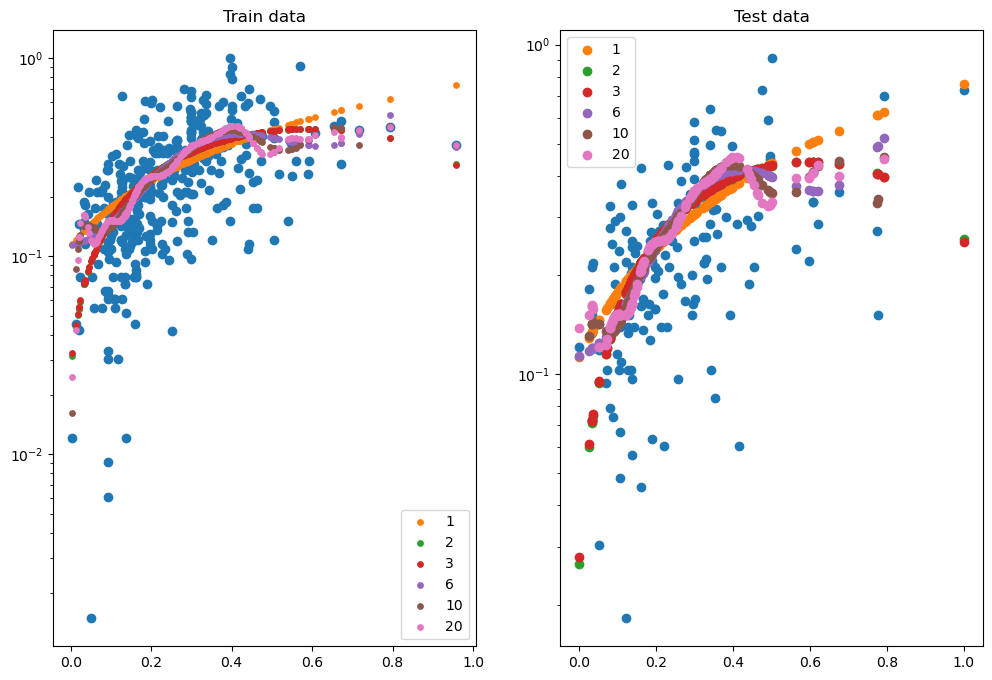

In [114]:
##visualizing the train and test predictions
#Note: y axis is along log scale

plt.figure(figsize=(12,8))

#train data
plt.subplot(121)
plt.scatter(X_train,y_train)
plt.yscale('log')
plt.title('Train data')
for i , degree in enumerate(degrees):
    plt.scatter(X_train,y_train_pred[:,i],s=15,label=str(degree))
    plt.legend(loc='best')
    
#test data
plt.subplot(122)
plt.scatter(X_test,y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):
    plt.scatter(X_test,y_test_pred[:,i],label=str(degree))
    plt.legend(loc='best')
    
plt.show()

In [115]:
#compare r2_score for train and test sets(for all polynomial fits)
from sklearn.metrics import r2_score
print('R-squared values:\n')

for i,degree in enumerate(degrees):
    train_r2 = round(r2_score(y_train,y_train_pred[:,i]),2)
    test_r2 = round(r2_score(y_test,y_test_pred[:,i]),2)
    print("R2_Score of Polynomial {0}: Train score{1}, Test score{2}".format(degree,train_r2,test_r2))

R-squared values:

R2_Score of Polynomial 1: Train score0.29, Test score0.25
R2_Score of Polynomial 2: Train score0.34, Test score0.22
R2_Score of Polynomial 3: Train score0.34, Test score0.22
R2_Score of Polynomial 6: Train score0.36, Test score0.11
R2_Score of Polynomial 10: Train score0.37, Test score-108.76
R2_Score of Polynomial 20: Train score0.38, Test score-307071892461.64


- Here we have built a model which is overfitting as the degrees of polynomial increases.
- Clearly the R2_score of Polynomial degree 20 is -ve and hence it is extremely overfitted model

### 1. Building a model without Cross Validation

In [116]:
## data preparation
data = pd.read_csv('Housing.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [117]:
data['furnishingstatus'].value_counts()

semi-furnished    227
unfurnished       178
furnished         140
Name: furnishingstatus, dtype: int64

In [118]:
data['parking'].value_counts()

0    299
1    126
2    108
3     12
Name: parking, dtype: int64

In [119]:
##list of all the "yes-no" binary categorical variables
#we will map yes to 1 and no to 0
binary_var_list = [i for i in data.columns if data[i].dtype=='O' and i not in ('furnishingstatus')]

#defining the map function
def binary_map(x):
    return x.map({'yes':1,"no":0})

##applying the binary_map function to the binary_var_list
data[binary_var_list] = data[binary_var_list].apply(binary_map)

In [120]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [121]:
##get dummy variables for furnishing status
status = pd.get_dummies(data['furnishingstatus'],drop_first=True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [122]:
##concatenating the dummy variables with dataFrame 'data'
df = pd.concat([data,status],axis=1)

In [123]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [124]:
#dropping the furnishingstatus column
df.drop('furnishingstatus',axis=1,inplace=True)

In [125]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


### Splitting into train and test

In [126]:
#train-test 70-30 split
df_train,df_test = train_test_split(df,test_size=0.3,train_size=.7,random_state=100)

#rescaling the features
scaler = MinMaxScaler()

#apply scaler() to all numeric columns
numeric_vars = ['price','area','bedrooms','bathrooms','stories','parking']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [127]:
##applying rescaling to the test set also
df_test[numeric_vars] = scaler.transform(df_test[numeric_vars])
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.229697,0.091869,0.4,0.0,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.484848,0.366420,0.4,0.5,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.303030,0.742080,0.4,0.0,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.242424,0.306582,0.4,0.0,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.227879,0.274023,0.6,0.0,0.333333,1,0,0,0,1,0.000000,0,1,0


In [128]:
##divide into X_train,y_train,X_test,y_test
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

### Using RFE (Recursive Feature Elimination)

In [130]:
##checking out the number of max features
len(X_train.columns)

13

In [131]:
##Let's first select the number of features as 10 and then check the r2_score
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,n_features_to_select=10)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [135]:
#checking out the features that have been selected by RFE, represented by True/False in tuple,and 
#if not selected mentioning the rank by the worst feature
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [136]:
##Predict the prices of X_test
y_pred = rfe.predict(X_test)

#evaluating r2_score
print(r2_score(y_test,y_pred))

0.6519767225566988


In [137]:
## Let's now check with another value of RFE
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,n_features_to_select=6)
rfe.fit(X_train,y_train)

##Predict the prices of X_test
y_pred = rfe.predict(X_test)

#evaluating r2_score
print(r2_score(y_test,y_pred))

0.6171279856258436


## Problems with manual hyperparameter tuning approach
- We are having a sneek into the test set everytime to checkout the model performance.
- The r2_score has been tested on a particular set alone.
- If we are splitting this into train,validation and test set then the validation set would eat into the train set.

### K-Cross Validation

In [138]:
#k-fold cv (using all the 13 features)
lm = LinearRegression()
scores = cross_val_score(lm,X_train,y_train,scoring='r2',cv =5)
scores

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

In [139]:
np.mean(scores)

0.6525844171909869

- Therefore 65.25 is the mean accuracy as per the k-fold cross validation on the validation set.

In [140]:
## the other way of doing the same thing.
folds = KFold(n_splits=5,shuffle=True,random_state=100)
scores = cross_val_score(lm,X_train,y_train,scoring ='r2',cv = folds)
scores

array([0.59930574, 0.71307628, 0.61325733, 0.62739077, 0.6212937 ])

In [141]:
np.mean(scores)

0.6348647642017535

- This is giving is almost the same result as of the previous method.

### Grid Search CV

In [164]:
##step 1: create a croos-validation scheme
folds = KFold(n_splits=5,shuffle=True,random_state=100)

##step 2:specify range of hyperparameters to tune
hyper_params = {'n_features_to_select':list(range(1,14))}

#step 3:perform GridSearch CV
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm)

## call GridSearchCV()
model_cv = GridSearchCV(estimator=rfe,
                       param_grid=hyper_params,
                       cv = folds,
                       verbose=1,
                       return_train_score=True)

#fit the model
model_cv.fit(X_train,y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid={'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13]},
             return_train_score=True, verbose=1)

In [165]:
#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.075587,0.074761,0.003594,0.000491,1,{'n_features_to_select': 1},0.172606,0.351721,0.206887,0.165910,...,0.243658,0.077627,13,0.302971,0.265961,0.280611,0.300768,0.269025,0.283867,0.015506
1,0.034272,0.000861,0.003989,0.000630,2,{'n_features_to_select': 2},0.335665,0.428751,0.439969,0.505321,...,0.438360,0.058374,12,0.505799,0.489802,0.462091,0.474178,0.471907,0.480755,0.015355
2,0.040837,0.011983,0.005383,0.002482,3,{'n_features_to_select': 3},0.421848,0.539257,0.491515,0.604426,...,0.516805,0.059902,11,0.568074,0.544917,0.542889,0.534685,0.542412,0.546596,0.011289
3,0.048582,0.010198,0.005691,0.002091,4,{'n_features_to_select': 4},0.449487,0.567101,0.494461,0.600237,...,0.526272,0.053074,10,0.587523,0.564018,0.549490,0.541496,0.549291,0.558364,0.016296
4,0.029649,0.002605,0.004366,0.000783,5,{'n_features_to_select': 5},0.494779,0.610200,0.492807,0.590812,...,0.541889,0.049257,8,0.620038,0.597033,0.584663,0.549413,0.589397,0.588109,0.022847
5,0.025721,0.001607,0.003391,0.000488,6,{'n_features_to_select': 6},0.512477,0.628849,0.488411,0.527379,...,0.541063,0.048029,9,0.626959,0.603122,0.596348,0.606852,0.601063,0.606869,0.010602
6,0.022756,0.001181,0.003792,0.000401,7,{'n_features_to_select': 7},0.568887,0.664093,0.552385,0.534634,...,0.577636,0.045006,7,0.658577,0.638501,0.630137,0.646285,0.638313,0.642363,0.009582
7,0.027725,0.016111,0.003590,0.000488,8,{'n_features_to_select': 8},0.570639,0.665608,0.592323,0.550001,...,0.591795,0.039428,6,0.674146,0.640825,0.654028,0.658665,0.657277,0.656988,0.010651
8,0.016755,0.000399,0.003620,0.000455,9,{'n_features_to_select': 9},0.578843,0.694189,0.606220,0.590777,...,0.615352,0.040767,4,0.676043,0.652605,0.659579,0.668996,0.664321,0.664309,0.007988
9,0.014362,0.000488,0.003390,0.000489,10,{'n_features_to_select': 10},0.574376,0.693197,0.601972,0.594335,...,0.608547,0.043498,5,0.686032,0.661729,0.674558,0.678443,0.677153,0.675583,0.007910


In [166]:
cv_results = cv_results[['params','mean_test_score','mean_train_score']]

In [167]:
cv_results

,params,mean_test_score,mean_train_score
0,{'n_features_to_select': 1},0.243658,0.283867
1,{'n_features_to_select': 2},0.438360,0.480755
2,{'n_features_to_select': 3},0.516805,0.546596
3,{'n_features_to_select': 4},0.526272,0.558364
4,{'n_features_to_select': 5},0.541889,0.588109
5,{'n_features_to_select': 6},0.541063,0.606869
6,{'n_features_to_select': 7},0.577636,0.642363
7,{'n_features_to_select': 8},0.591795,0.656988
8,{'n_features_to_select': 9},0.615352,0.664309
9,{'n_features_to_select': 10},0.608547,0.675583


In [168]:
for i in range(0,13):
    cv_results['params'][i] = cv_results['params'][i]['n_features_to_select']

In [169]:
cv_results

,params,mean_test_score,mean_train_score
0,1,0.243658,0.283867
1,2,0.438360,0.480755
2,3,0.516805,0.546596
3,4,0.526272,0.558364
4,5,0.541889,0.588109
5,6,0.541063,0.606869
6,7,0.577636,0.642363
7,8,0.591795,0.656988
8,9,0.615352,0.664309
9,10,0.608547,0.675583


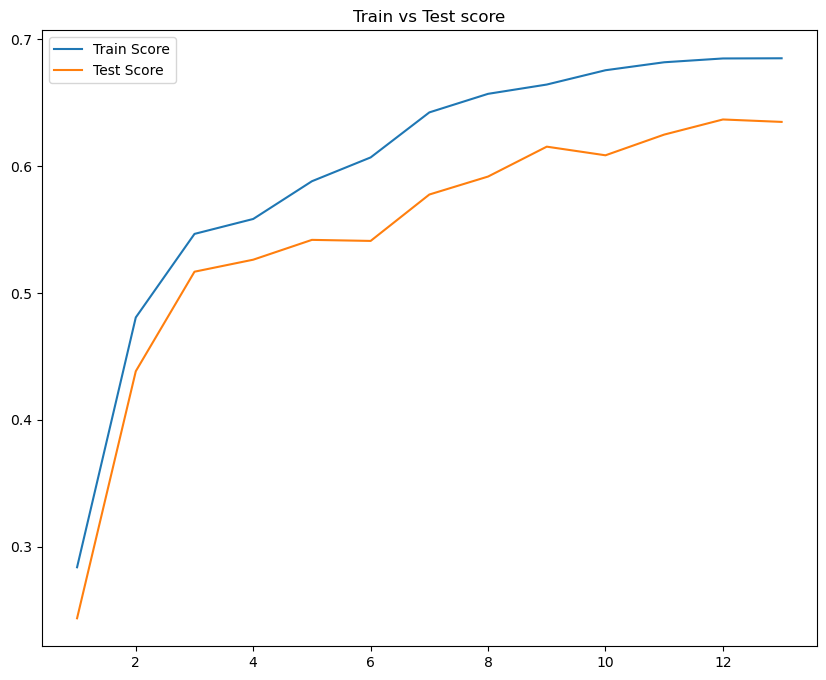

In [173]:
##Lets' now plot the train and test score to check out the optimal params value
plt.figure(figsize=(10,8))
plt.plot(cv_results['params'],cv_results['mean_train_score'],label='Train Score')
plt.plot(cv_results['params'],cv_results['mean_test_score'],label='Test Score')
plt.legend(loc='best')
plt.title('Train vs Test score')
plt.show()

In [174]:
## Let's chose the optimal value as 10 here
#final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train,y_train)

rfe= RFE(lm,n_features_to_select=n_features_optimal)
rfe.fit(X_train,y_train)

#Test scores
y_pred = rfe.predict(X_test)
score= r2_score(y_test,y_pred)
score

0.6519767225566988

- As per our observation the test score is even greater than the score that has been predicted on the validation set.